#### Modelo para medir a fidelidade ao consumo
- a fidelidade pode ser medida com o retorno a loja menor que um período determinando

In [2]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise
from scipy import stats # estatística chi2
import plotly.graph_objects as go # gráficos 3D
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo
                                                        #logístico multinomial
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score
import warnings
warnings.filterwarnings('ignore')



In [4]:
# carregar dados
df_fidelidade = pd.read_csv(r'Script e Project\dados_fidelidade.csv', delimiter=',')
df_fidelidade.head()


,id,fidelidade,sexo,idade,atendimento,sortimento,acessibilidade,preço
0,1,nao,feminino,34,2,2,1,1
1,2,nao,feminino,34,2,2,1,1
2,3,nao,masculino,34,3,2,4,2
3,4,nao,feminino,34,4,3,3,3
4,5,nao,feminino,34,4,3,1,4


- variável y: fidelidade
- variavel x: sexo (qualitativa), transformar em dummy
- variavel x: idade, quantitativa
- variavel x: atendimento (qualitativa), transformar em dummy
- variavel x: sortimento (qualitativa), transformar em dummy
- variavel x: acessibilidade (qualitativa), transformar em dummy
- variavel x: preço (qualitativa), transformar em dummy


<!--  -->

In [7]:
# transformar id em str
df_fidelidade['id'] = df_fidelidade['id'].astype('str') 

# transformar as variáveis explicativas qualitativas para o tipo object
df_fidelidade['atendimento'] = df_fidelidade['atendimento'].astype('object')
df_fidelidade['sortimento'] = df_fidelidade['sortimento'].astype('object')
df_fidelidade['acessibilidade'] = df_fidelidade['acessibilidade'].astype('object')
df_fidelidade['preço'] = df_fidelidade['preço'].astype('object')


In [9]:
df_fidelidade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3000 non-null   object
 1   fidelidade      3000 non-null   object
 2   sexo            3000 non-null   object
 3   idade           3000 non-null   int64 
 4   atendimento     3000 non-null   object
 5   sortimento      3000 non-null   object
 6   acessibilidade  3000 non-null   object
 7   preço           3000 non-null   object
dtypes: int64(1), object(7)
memory usage: 187.6+ KB


In [10]:
df_fidelidade.describe()

,idade
count,3000.00000
mean,34.21000
std,1.57058
min,29.00000
25%,34.00000
50%,34.00000
75%,34.00000
max,42.00000


In [12]:
df_fidelidade['fidelidade'].value_counts()

fidelidade
sim    1680
nao    1320
Name: count, dtype: int64

In [13]:
df_fidelidade['sexo'].value_counts()

sexo
feminino     2400
masculino     600
Name: count, dtype: int64

In [14]:
df_fidelidade['atendimento'].value_counts().sort_index()

atendimento
1     150
2     300
3     750
4    1530
5     270
Name: count, dtype: int64

In [15]:
df_fidelidade['sortimento'].value_counts().sort_index()

sortimento
1     330
2     420
3     570
4    1200
5     480
Name: count, dtype: int64

In [16]:
df_fidelidade['acessibilidade'].value_counts().sort_index()

acessibilidade
1     420
2      90
3    1410
4     240
5     840
Name: count, dtype: int64

In [17]:
df_fidelidade['preço'].value_counts().sort_index()

preço
1     180
2     270
3    1170
4     990
5     390
Name: count, dtype: int64

In [19]:
# transformar a variável Y para 0 e 1 para o tipo 'int' para estimar o modelo
df_fidelidade.loc[df_fidelidade['fidelidade']=='sim', 'fidelidade'] = 1
df_fidelidade.loc[df_fidelidade['fidelidade']=='nao', 'fidelidade'] = 0
df_fidelidade['fidelidade'] = df_fidelidade['fidelidade'].astype(int)


In [20]:
df_fidelidade.head()

,id,fidelidade,sexo,idade,atendimento,sortimento,acessibilidade,preço
0,1,0,feminino,34,2,2,1,1
1,2,0,feminino,34,2,2,1,1
2,3,0,masculino,34,3,2,4,2
3,4,0,feminino,34,4,3,3,3
4,5,0,feminino,34,4,3,1,4


In [21]:
# transformar em dummy as variáveis: sexo, atendimento, sortimento, acessibilidade e preço
df_fidelidade_dummies = pd.get_dummies(df_fidelidade,
                                       columns=['sexo',
                                                'atendimento',
                                                'sortimento',
                                                'acessibilidade',
                                                'preço'],
                                                dtype='int',
                                                drop_first=True)
 
df_fidelidade_dummies

,id,fidelidade,idade,sexo_masculino,atendimento_2,atendimento_3,atendimento_4,atendimento_5,sortimento_2,sortimento_3,sortimento_4,sortimento_5,acessibilidade_2,acessibilidade_3,acessibilidade_4,acessibilidade_5,preço_2,preço_3,preço_4,preço_5
0,1,0,34,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2,0,34,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,0,34,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0
3,4,0,34,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0
4,5,0,34,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,1,34,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2996,2997,1,34,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0
2997,2998,1,36,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
2998,2999,1,35,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0


In [22]:
# estimação do modelo
lista_colunas = list(df_fidelidade_dummies.drop(columns=['id','fidelidade']).columns)

In [23]:
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = 'fidelidade ~' + formula_dummies_modelo
print('Fórmula utilizada: ', formula_dummies_modelo)

Fórmula utilizada:  fidelidade ~idade + sexo_masculino + atendimento_2 + atendimento_3 + atendimento_4 + atendimento_5 + sortimento_2 + sortimento_3 + sortimento_4 + sortimento_5 + acessibilidade_2 + acessibilidade_3 + acessibilidade_4 + acessibilidade_5 + preço_2 + preço_3 + preço_4 + preço_5


In [25]:
modelo_fidelidade = sm.Logit.from_formula(formula_dummies_modelo,df_fidelidade_dummies).fit()
print(modelo_fidelidade.summary())

Optimization terminated successfully.
         Current function value: 0.257856
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             fidelidade   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2981
Method:                           MLE   Df Model:                           18
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                  0.6241
Time:                        12:43:18   Log-Likelihood:                -773.57
converged:                       True   LL-Null:                       -2057.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -68.9866      6.055    -11.394      0.000     -80.854     -57.120
idade      

In [26]:
# procedimento stepwise
# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

from statstests.process import stepwise

# estimação do modelo por meio do procedimento stepwise
step_modelo_fidelidade = stepwise(modelo_fidelidade, pvalue_limit=0.05)




Regression type: Logit 

Estimating model...: 
 fidelidade ~ Q('idade') + Q('sexo_masculino') + Q('atendimento_2') + Q('atendimento_3') + Q('atendimento_4') + Q('atendimento_5') + Q('sortimento_2') + Q('sortimento_3') + Q('sortimento_4') + Q('sortimento_5') + Q('acessibilidade_2') + Q('acessibilidade_3') + Q('acessibilidade_4') + Q('acessibilidade_5') + Q('preço_2') + Q('preço_3') + Q('preço_4') + Q('preço_5')
Optimization terminated successfully.
         Current function value: 0.257856
         Iterations 9

 Discarding atribute "Q('preço_2')" with p-value equal to 0.7880570577805589 

Estimating model...: 
 fidelidade ~ Q('idade') + Q('sexo_masculino') + Q('atendimento_2') + Q('atendimento_3') + Q('atendimento_4') + Q('atendimento_5') + Q('sortimento_2') + Q('sortimento_3') + Q('sortimento_4') + Q('sortimento_5') + Q('acessibilidade_2') + Q('acessibilidade_3') + Q('acessibilidade_4') + Q('acessibilidade_5') + Q('preço_3') + Q('preço_4') + Q('preço_5')
Optimization terminated succes

In [27]:
# construção de função para a definição da matriz de confusão
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

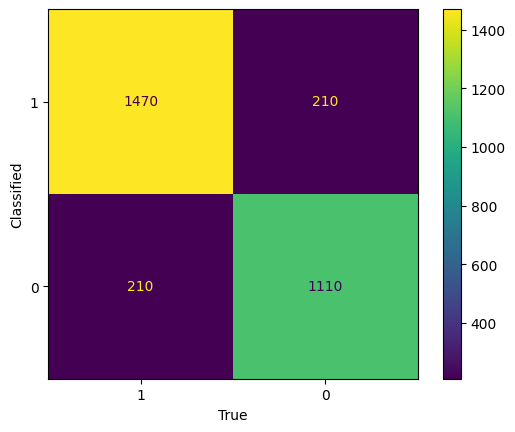

,Sensitividade,Especificidade,Acurácia
0,0.875,0.840909,0.86


In [28]:
# adicionando os valores previstos de probabilidade na base de dados
df_fidelidade_dummies['phat'] = step_modelo_fidelidade.predict()

# matriz de confusão para cutoff = 0.5
matriz_confusao(observado=df_fidelidade_dummies['fidelidade'],
                predicts=df_fidelidade_dummies['phat'],
                cutoff=0.50)

In [30]:
# Criação da função 'espec_sens' para a construção de um dataset com diferentes
# valores de cutoff, sensitividade e especificidade:

def espec_sens(observado,predicts):
    
    # adicionar objeto com os valores dos predicts
    values = predicts.values
    
    # range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado


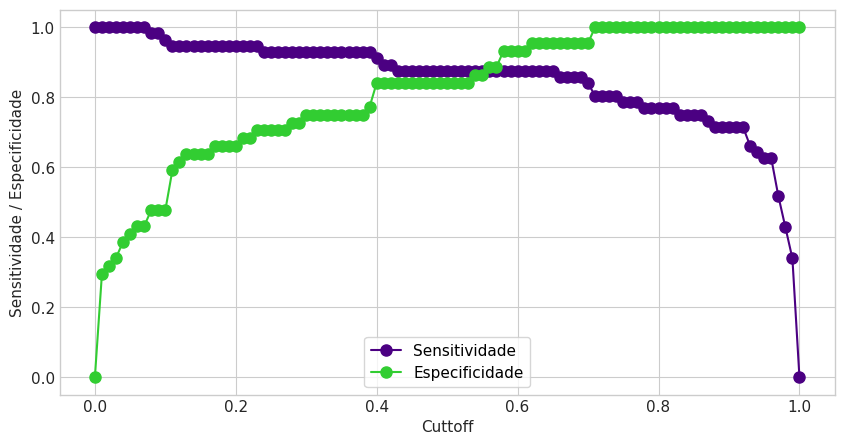

In [32]:
# plotagem de um gráfico que mostra a variação da especificidade e da sensitividade em função do cutoff
dados_plotagem = espec_sens(observado = df_fidelidade_dummies['fidelidade'],
                            predicts = df_fidelidade_dummies['phat'])


plt.figure(figsize=(10,5))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o',
         color='indigo', markersize=8)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=11)
plt.ylabel('Sensitividade / Especificidade', fontsize=11)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=11)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=11)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=11)
plt.show()


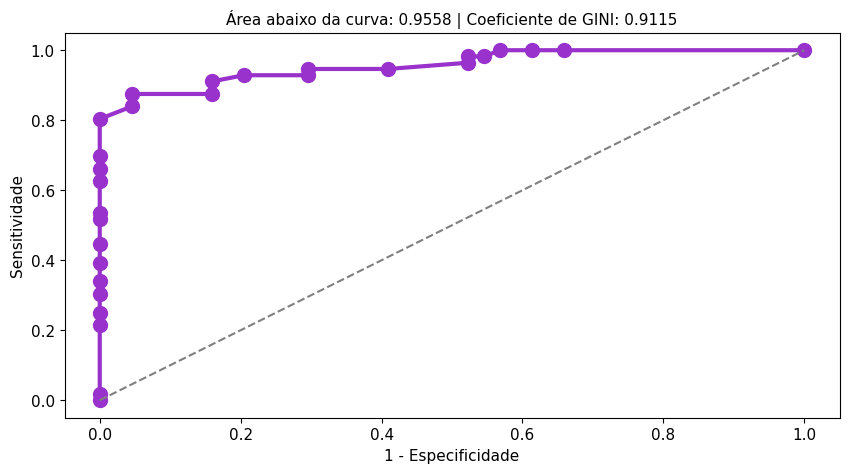

In [34]:
# construção da curva ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds =  roc_curve(df_fidelidade_dummies['fidelidade'],
                                  df_fidelidade_dummies['phat'])

roc_auc = auc(fpr,tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=11)
plt.xlabel('1 - Especificidade', fontsize=11)
plt.ylabel('Sensitividade', fontsize=11)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=11)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=11)
plt.show()


- uma área abaixo da curva de 0,9558 indica que o modelo logístico binário tem uma boa capacidade de discriminação entre as classes